In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

##### Warning taken from the accompanying notebook: Since Scikit-Learn 0.24, fetch_openml() returns a Pandas DataFrame by default. To avoid this, we use as_frame=False.

In [2]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

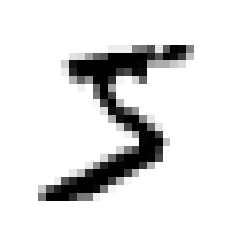

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np
y = y.astype(np.uint8)

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] #dataset is already split & shuffled

# Training a Binary Classifier

In [8]:
y_train_5 = (y_train == 5) #Returns True for all 5's and false for non-5's
y_test_5 = (y_test == 5)

#Starting with Stochastic Gradient Classifier (SGD), which is very very efficient at handling large datasets

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) #SGDClassifier relies on randomness during training, hence random_state must be set
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit]) #X[0] contains a 5, hence prediction is correct

array([ True])

# Evaluating performance of the model

## Using Cross-Validation

### Implementing Cross-Validation

In [10]:
#Implementing cross-validation for more fine control
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True) 
#Shuffle to be set to True or leave random_state to default

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)                  #Creating a clone of the classifier
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds) #Training the clone on train folds
    y_pred = clone_clf.predict(X_test_fold)     #Making predictions on test folds
    n_correct = sum(y_pred == y_test_fold)      #Count the no. of correct predictions
    print(n_correct/len(y_pred))                #Output the ratio of correct predictions

0.9669
0.91625
0.96785


In [11]:
#Evaluating SGDClassifier using cross_val_score with 3 folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

While we got above 95% accuracy, let's first run a dumb classifier that clasifies every single image that is not 5.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y= None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

91% accuracy here. Only about 10% of the images are 5s, so 90% of the time the classifier guesses an image is not a 5. 
So Accuracy is not a preferred performance measure for classifiers, especially when dealing with skewed classes.

## Confusion Matrix

Confusion matrix is a better way to evaluate the performance of a classifier.
The idea is to count the no. of times instances of Class A are classified as Class B.
For ex, to know the no. of times the classifier confused images of 5s with 3s, we should look at 5th row of 3rd column of the confusion matrix.
We need to first have a set of predictions, before we compute the confusion matrix. We shall use cross_val_predict() function, so that we only make predictions on test set once we have model ready and we are at the end of the project.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

cross_val_predict() also performs K-fold cross-validation, but returns the predictions made on each test fold instead of returning the evaluation scores.

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

This confusion Matrix can be represented as below for clarity:

    True negatives       False Positives            ---> Negative class
    False negatives      True positives             ---> Positive class
    
Each row represents an actual class, while each column represents a predicted class.
So 53,892 were correctly classified as non-5s while 687 were wrongly classified as 5s.
    1,891 were wrongly classified as non-5s while 3530 were correctly classified as 5s.
    
A perfect classifier would have only true positives and true negatives in its confusion matrix, i.e., a diagonal matrix with other elements being zeros.

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

This above output is an example of a perfect prediction.

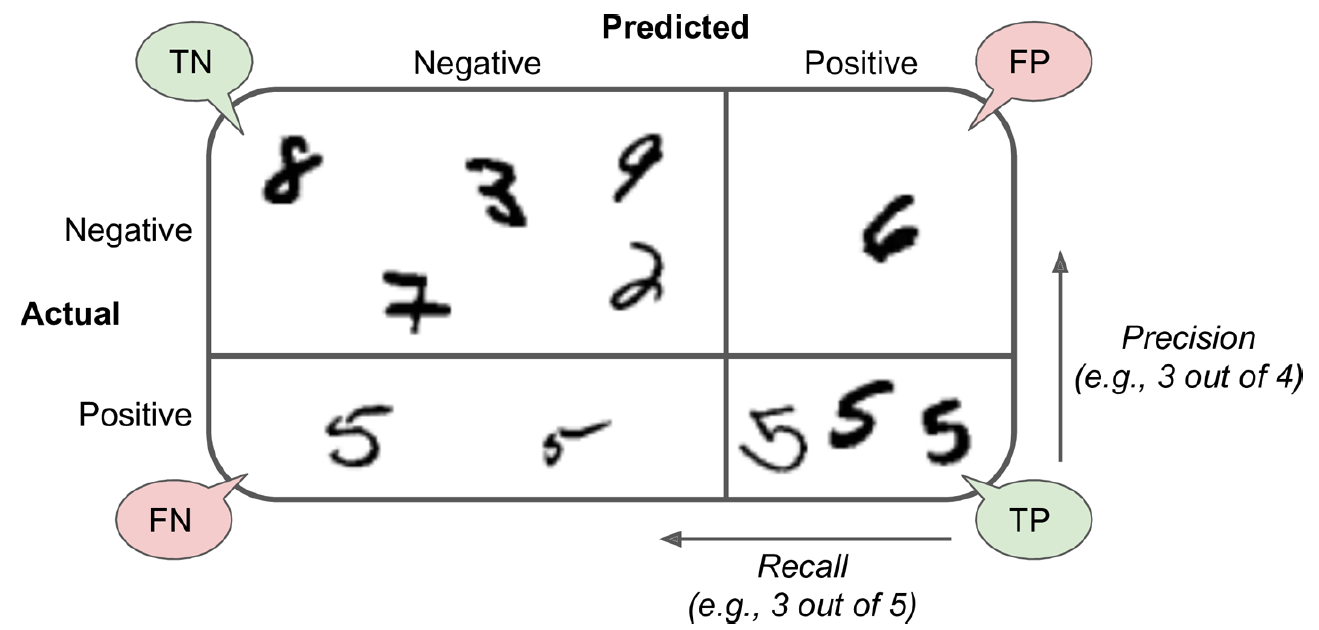

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

So at 83.7% precision, the classifier is correct 83.% of the time when it says an image is a 5.

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

F1 score favours classifiers that have similar precision & recall. But this isn't always the desired outcome as it depends on the case. 
Increasing precision reduces recall and vice versa. This is called precision/recall trade-off.

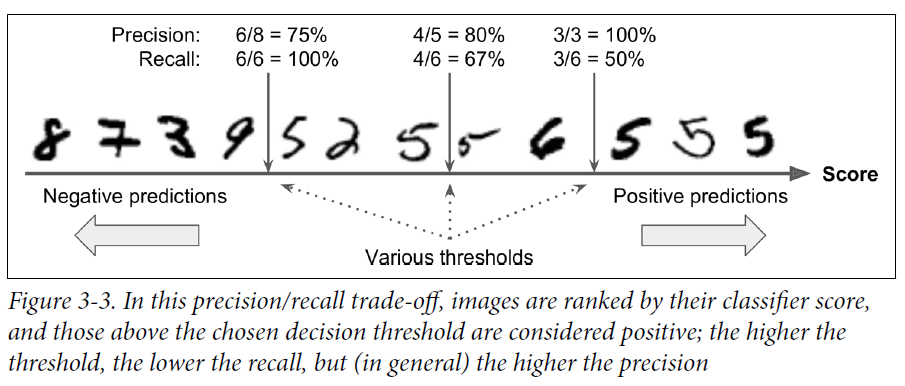

Scikit-learn provides decision_function() which returns a score for each instance, and then use any threshold that we want to make predictions based on those scores.

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

We can use the following method to decide on which threshold to use:

1) First, use the cross_val_predict() function to get scores of all instances in the training set, but specify that the function return the decision scores instead of predictions.

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method='decision_function')

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds.

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

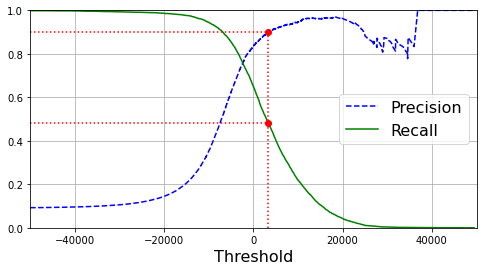

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Recall")
    plt.legend(loc="center right", fontsize = 16)
    plt.xlabel("Threshold", fontsize = 16)
    plt.grid(True)
    plt.axis([-50000,50000,0,1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], 'r:')
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([threshold_90_precision], [0.9], 'ro')
plt.plot([threshold_90_precision], [recall_90_precision], 'ro')
plt.savefig("precision_recall_vs_threshold_plot")
plt.show()

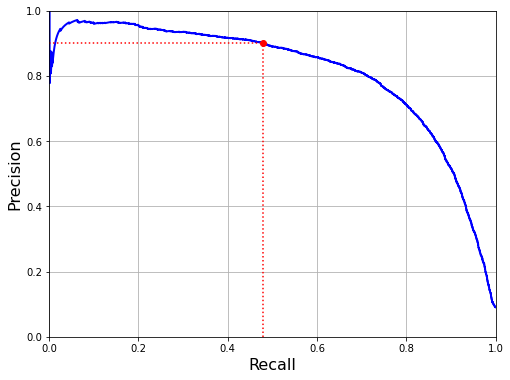

In [26]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-', linewidth = 2)
    plt.xlabel("Recall", fontsize = 16)
    plt.ylabel("Precision", fontsize = 16)
    plt.axis([0,1,0,1])
    plt.grid(True)


plt.figure(figsize=(8,6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0, 0.9], 'r:')
plt.plot([0, recall_90_precision], [0.9, 0.9], 'r:')
plt.plot([recall_90_precision], [0.9], 'ro')
plt.savefig("precision_vs_recall_plot")
plt.show()

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 90)]
#search for the lowest threshold that gives at least 90% precision.

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.0904012273621719

In [30]:
recall_score(y_train_5, y_train_pred_90)

1.0

## ROC Curve
Receiver Operating Characteristic (ROC) curve plots the true positive rate (recall) against the false positive rate (FPR).
FPR is the ratio of negative instances that are falsely classified as positive.

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

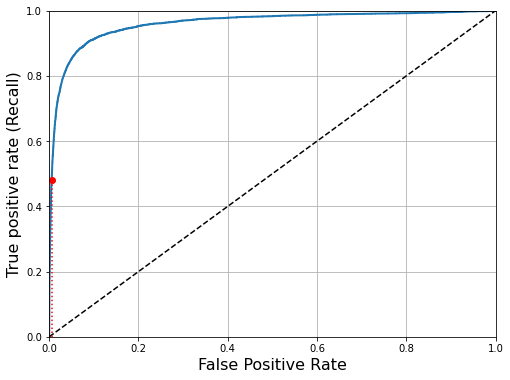

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate", fontsize = 16)
    plt.ylabel("True positive rate (Recall)", fontsize = 16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]
plt.plot([fpr_90, fpr_90], [0, recall_90_precision], 'r:')
plt.plot([0, fpr_90], [recall_90_precision, recall_90_precision], 'r:')
plt.plot([fpr_90], [recall_90_precision], 'ro')
plt.savefig("roc_curve_plot")
plt.show()

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method='predict_proba')

In [35]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

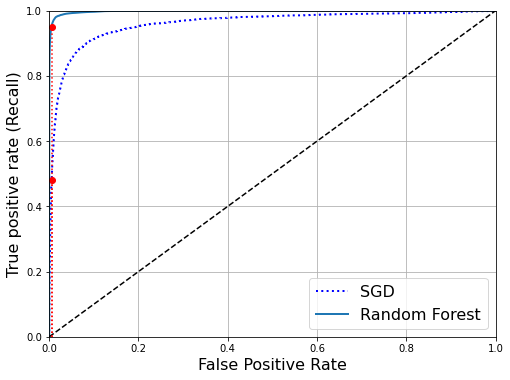

In [36]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.savefig("roc_curve_comparison_plot")
plt.show()

In [37]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145